### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Reading the Dataset

In [2]:
# reading the dataset to a pandas dataframe
df = pd.read_table('~/Desktop/airfoil_self_noise.dat',header=None, sep='\t')
df.head()

,0,1,2,3,4,5
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


### Exploratory Data Analysis of given dataset

In [3]:
# the column names are missing from the dataframe so adding meaningful column names
df.columns = ['Freq', 'Alpha', 'Chord_Length', 'Velocity', 'Thickness' , 'SSPL']
df.head()

,Freq,Alpha,Chord_Length,Velocity,Thickness,SSPL
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [4]:
# checking shape of dataset
df.shape

(1503, 6)

In [5]:
# checking datatypes of columns and non-null count
df.info() # the datatypes are correct and there are no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Freq          1503 non-null   int64  
 1   Alpha         1503 non-null   float64
 2   Chord_Length  1503 non-null   float64
 3   Velocity      1503 non-null   float64
 4   Thickness     1503 non-null   float64
 5   SSPL          1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [6]:
# checking 0 values in all columns
df.all()
# Alpha column has 0 values

Freq             True
Alpha           False
Chord_Length     True
Velocity         True
Thickness        True
SSPL             True
dtype: bool

In [7]:
# checking number of 0 values in Alpha column
(df['Alpha']==0).sum()

329

<AxesSubplot:xlabel='Alpha', ylabel='count'>

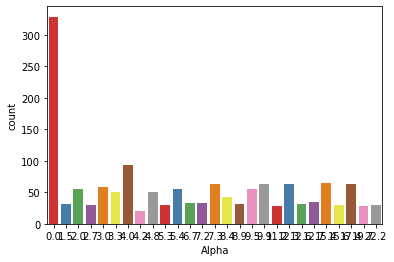

In [8]:
# checking number of 0 values in Alpha column graphically
sns.countplot(x="Alpha", data=df,palette="Set1")

In [9]:
# there are 329 missing values in alpha column. If according to the dataset alpha is not supposed to have a 0 then we might consier removing such rows


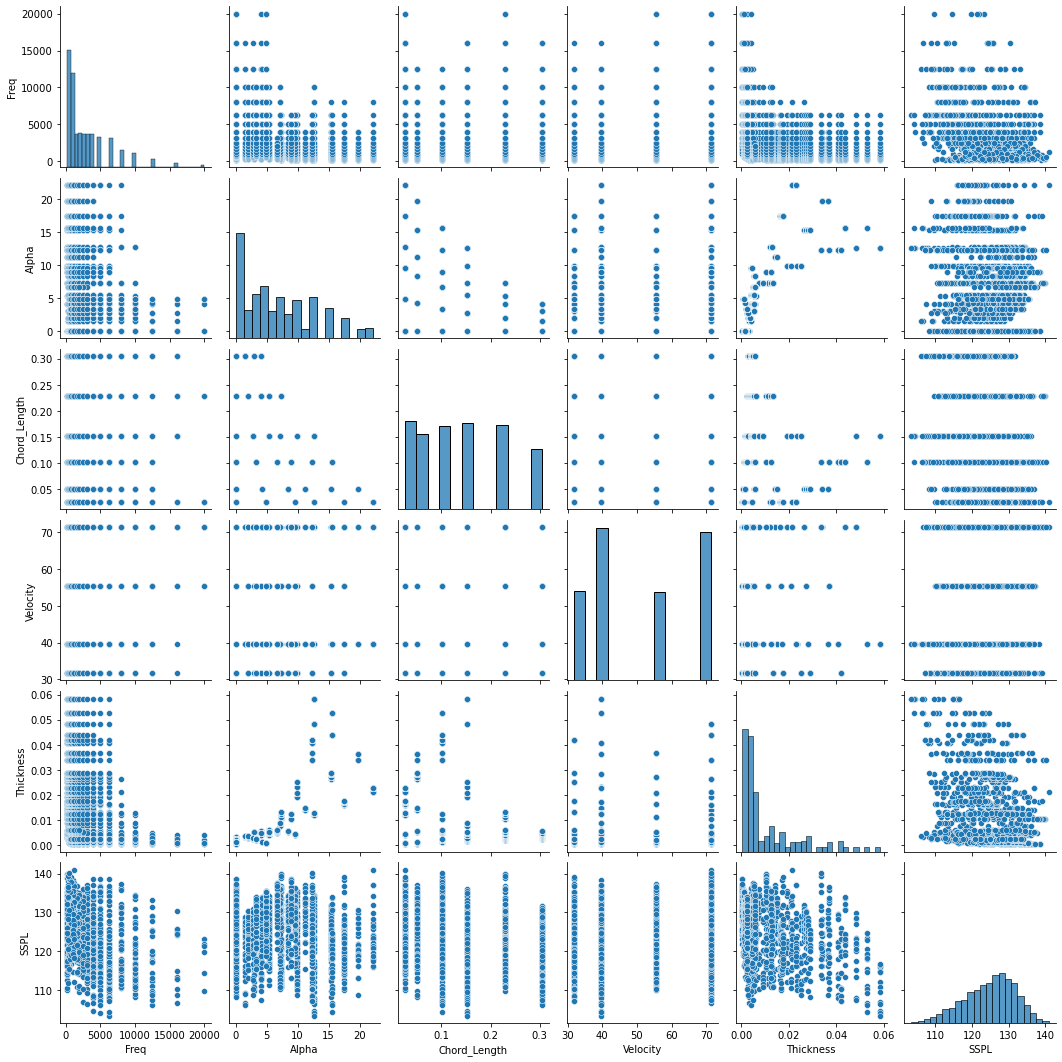

In [10]:
#scatter plot to see multiple pairwise bivariate distributions
sns.pairplot(df)
plt.show()

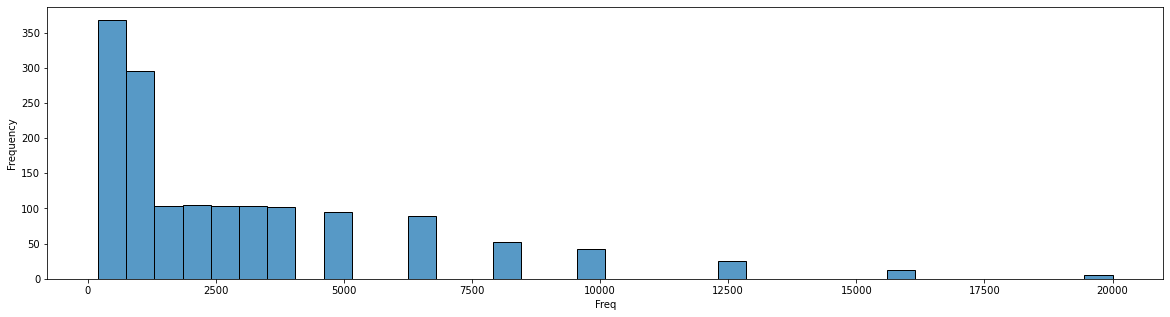

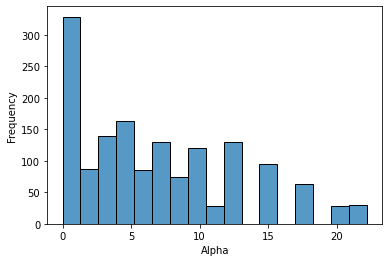

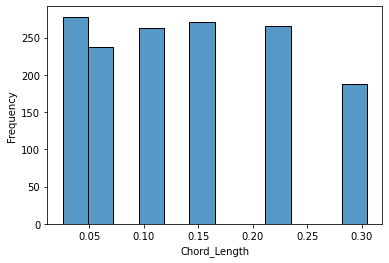

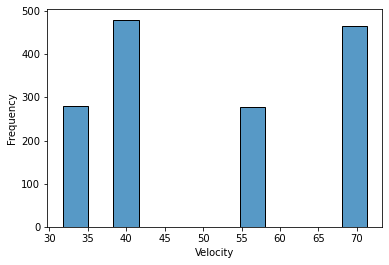

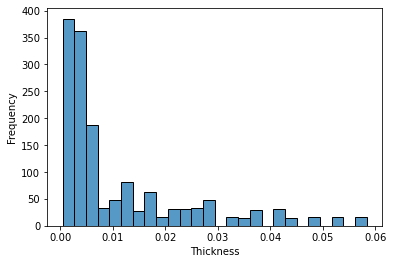

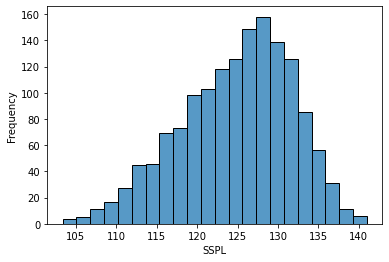

In [11]:
# visualizing the distribution of data
columns = list(df.columns)
plt.figure(figsize=(20, 5))
for i in columns:
    g = sns.histplot(df[i])
    g.set(xlabel=i, ylabel='Frequency')
    plt.show()

In [12]:
# from above plot we see-
# Freq with value closer to 0 has the highest count
# Alpha with value 0 has the highest count
# there are 6 types of chord length
# velocity has 4 distinct values here
# thickness also has more count of value closer to 0

In [13]:
# describing the dataframe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Freq,1503.0,2886.380572,3152.573137,200.000000,800.000000,1600.000000,4000.000000,20000.000000
Alpha,1503.0,6.782302,5.918128,0.000000,2.000000,5.400000,9.900000,22.200000
Chord_Length,1503.0,0.136548,0.093541,0.025400,0.050800,0.101600,0.228600,0.304800
Velocity,1503.0,50.860745,15.572784,31.700000,39.600000,39.600000,71.300000,71.300000
Thickness,1503.0,0.011140,0.013150,0.000401,0.002535,0.004957,0.015576,0.058411
SSPL,1503.0,124.835943,6.898657,103.380000,120.191000,125.721000,129.995500,140.987000


In [14]:
# std of Freq is very high indicating a huge variation of data points from the mean
# Freq column has value huge range as compared to columns like Thickness, chord_length
# max value of Freq = 20000 while Thickness has 0.058 
# due to this huge difference of ranges we must to a standardization/normalization

In [15]:
# lets visualize each column through box plots

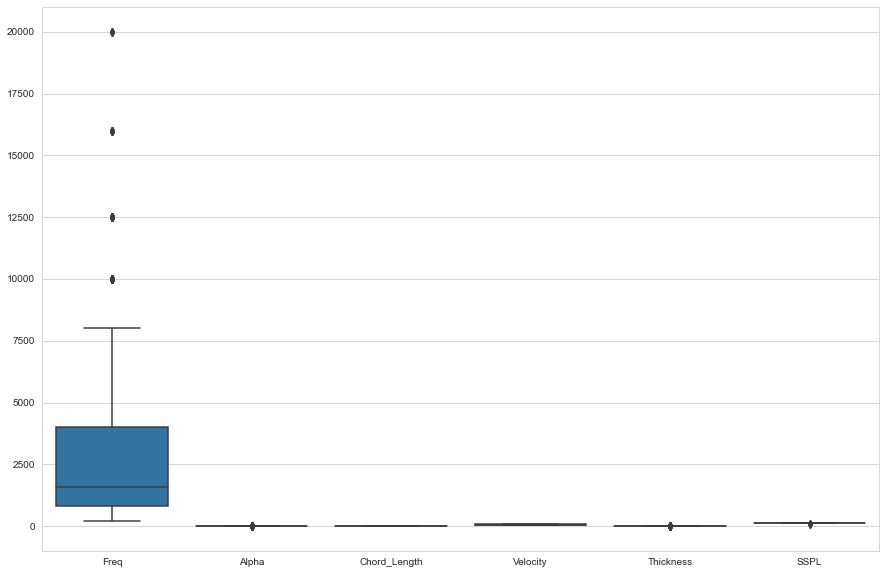

In [16]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.show();
# we see few outliers in frequency

In [17]:
# checking the pairwise correlation of all columns
corr = df.corr()
corr

,Freq,Alpha,Chord_Length,Velocity,Thickness,SSPL
Freq,1.000000,-0.272765,-0.003661,0.133664,-0.230107,-0.390711
Alpha,-0.272765,1.000000,-0.504868,0.058760,0.753394,-0.156108
Chord_Length,-0.003661,-0.504868,1.000000,0.003787,-0.220842,-0.236162
Velocity,0.133664,0.058760,0.003787,1.000000,-0.003974,0.125103
Thickness,-0.230107,0.753394,-0.220842,-0.003974,1.000000,-0.312670
SSPL,-0.390711,-0.156108,-0.236162,0.125103,-0.312670,1.000000


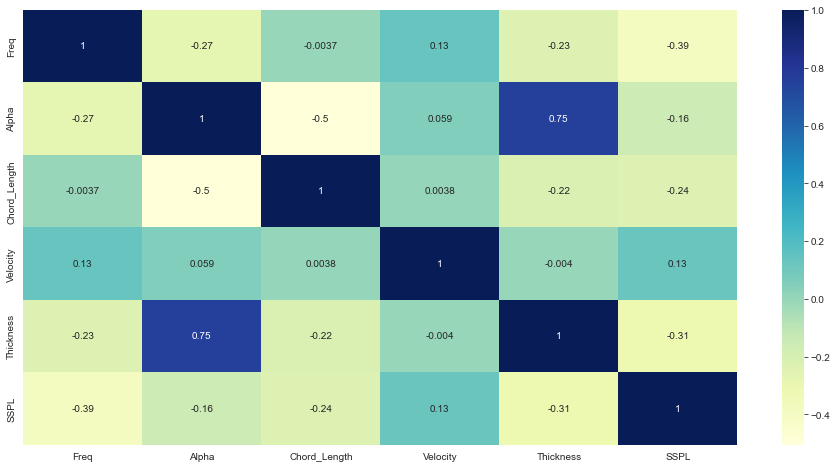

In [18]:
# visualizing the correlation using heatmap
# using Heatmap to understand pairwise correlation of all columns
# Figure size
plt.figure(figsize=(16,8))

sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

In [19]:
# there is high correlation between alpha and thickness, one may be removed
# target variable SSPL has high correlation with freq and thickness
# as target variable has high correlation with Thickness we will consider removing Alpha

### A function to normalizing data Using MinMaxScaler

In [20]:
def scaleData(dataFrame):
    scaler = MinMaxScaler()
    return scaler.fit_transform(dataFrame)

### 1) Fitting Linear Regression Model on entire Dataset to check various evalution metric

In [21]:
# scaling data using minmax scaler
dfScaled = scaleData(df)
dfScaled

array([[0.03030303, 0.        , 1.        , 1.        , 0.03900472,
        0.60682852],
       [0.04040404, 0.        , 1.        , 1.        , 0.03900472,
        0.58023772],
       [0.0530303 , 0.        , 1.        , 1.        , 0.03900472,
        0.60018082],
       ...,
       [0.19191919, 0.7027027 , 0.27272727, 0.19949495, 0.90411066,
        0.08572872],
       [0.24242424, 0.7027027 , 0.27272727, 0.19949495, 0.90411066,
        0.07562422],
       [0.30808081, 0.7027027 , 0.27272727, 0.19949495, 0.90411066,
        0.02191081]])

In [22]:
# dividing data into dependant and independant variables
temp = dfScaled.copy()
x = np.delete(dfScaled,4,1) # dropping SSPL from independant variables
y = temp[:,4] # adding only SSPL - target variable

In [23]:
# checking size of independant variables
x.shape

(1503, 5)

In [24]:
# checking size of dependant variables
y.shape

(1503,)

In [25]:
# spliting train and test dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1127, 5)
(376, 5)
(1127,)
(376,)


In [26]:
# fitting Linear Regression model
model = LinearRegression().fit(X_train, y_train)

In [27]:
# predicting values for test data
predictions = model.predict(X_test)

In [46]:
# calculating R square for test and train set
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print("coefficient of determination of train set:{}".format(train_score))
print("coefficient of determination of test set:{}".format(test_score))

coefficient of determination of train set:0.45602838374076604
coefficient of determination of test set:0.5350082457998184


In [29]:
# calculating mae for test set
mae = mean_absolute_error(predictions, y_test)
print("Mean Absolute Error :", round(mae, 2))

Mean Absolute Error : 0.09


In [30]:
# calculating mae from scratch
predictions = list(predictions)
y_test = list(y_test)
def meanAbsoluteError(actual, predicted):
    sumError = 0.0
    for i in range(len(actual)):
        sumError += abs(predicted[i] - actual[i])
    return sumError / float(len(actual))

res = meanAbsoluteError(y_test,predictions)

print("Mean Absolute Error :", round(mae, 2))

Mean Absolute Error : 0.09


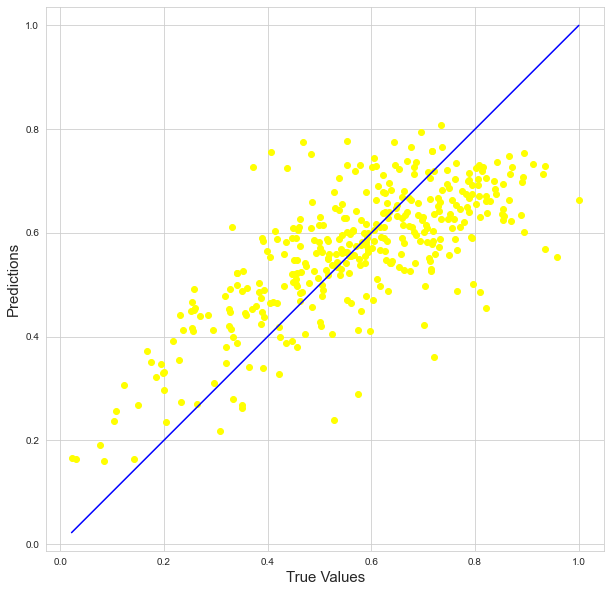

In [47]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, c ='yellow')

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### 2) Dropping Alpha column and fitting Linear Regression model to check various evalution metric

In [31]:
dfNew = df.drop(['Alpha'],axis=1) # removing alpha 

In [32]:
# scaling data using minmax scaler
dfScaled = scaleData(dfNew)
dfScaled

array([[0.03030303, 1.        , 1.        , 0.03900472, 0.60682852],
       [0.04040404, 1.        , 1.        , 0.03900472, 0.58023772],
       [0.0530303 , 1.        , 1.        , 0.03900472, 0.60018082],
       ...,
       [0.19191919, 0.27272727, 0.19949495, 0.90411066, 0.08572872],
       [0.24242424, 0.27272727, 0.19949495, 0.90411066, 0.07562422],
       [0.30808081, 0.27272727, 0.19949495, 0.90411066, 0.02191081]])

In [33]:
# dividing data into dependant and independant variables
temp = dfScaled.copy()
x = np.delete(dfScaled,4,1) # dropping SSPL from independant variables
y = temp[:,4] # adding only SSPL - target variable

In [34]:
# checking size of independant variables
x.shape

(1503, 4)

In [35]:
# checking size of dependant variables
y.shape

(1503,)

In [36]:
# spliting train and test dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1127, 4)
(376, 4)
(1127,)
(376,)


In [37]:
# fitting Linear Regression model
model = LinearRegression().fit(X_train, y_train)

In [38]:
# predicting values for test data
predictions = model.predict(X_test)

In [39]:
# calculating R square for test and train set
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print("coefficient of determination of train set:{}".format(train_score))
print("coefficient of determination of test set:{}".format(test_score))

coefficient of determination of train set:0.45602838374076604
coefficient of determination of test set:0.5350082457998184


In [40]:
# calculating mae for test set
mae = mean_absolute_error(predictions, y_test)
print("Mean Absolute Error :", round(mae, 2))

Mean Absolute Error : 0.1


In [41]:
# calculating mae from scratch
predictions = list(predictions)
y_test = list(y_test)
def meanAbsoluteError(actual, predicted):
    sumError = 0.0
    for i in range(len(actual)):
        sumError += abs(predicted[i] - actual[i])
    return sumError / float(len(actual))

res = meanAbsoluteError(y_test,predictions)

print("Mean Absolute Error :", round(res, 2))

Mean Absolute Error : 0.1


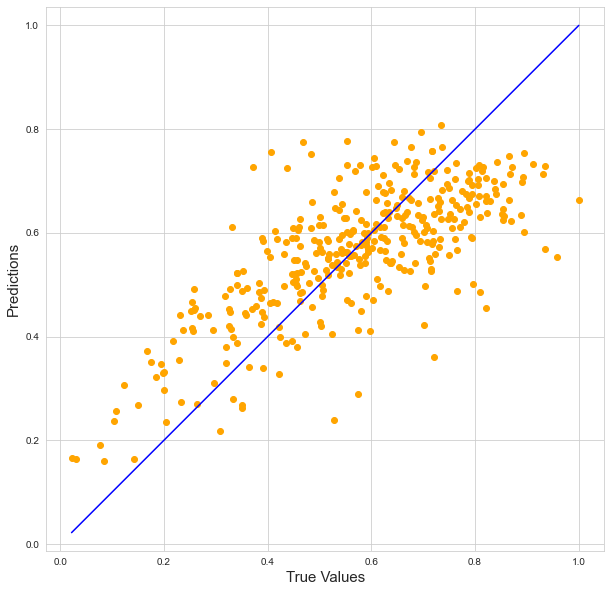

In [48]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, c='orange')

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### Conclusion

In [49]:
# I found out the MAE two times, once with all the features and next time by dropping one column Alpha
# Alpha and Thickness were both highly correlated with each other and thus any one could be removed
# but by checking correlation with target variable it was found that Thickness had higher correlation and thus I removed Alpha column
# MAE on full dataset

In [50]:
# MAE tells us the magnitude of difference between the prediction and the true value
# MAE for model on full dataset : 0.09
# MAE for model after dropping Alpha : 0.1